# MIMIC-IV Clinical Notes Exploration

This notebook explores the structure and content of MIMIC-IV clinical notes to inform model selection for text processing. We analyze:
- **Discharge summaries** and **Radiology reports**
- Text length distributions to determine if we need standard BERT (512 tokens) or Longformer/ModernBERT (8k+ tokens)
- Linkage between text files and metadata (_detail) files

**Context**: Preparing unstructured clinical text for an RL agent (P-CAFE).

## Section 1: Setup & Imports

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import numpy as np

# Set plot style for better readability
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## Section 2: Define File Paths

Update these paths to match your MIMIC-IV data location. The files should be in the `note` module of MIMIC-IV.

In [2]:
# Define file paths - Update these to match your data location
# Standard MIMIC-IV structure: physionet.org/files/mimiciv/3.1/note/

# Adjust this base path to your MIMIC-IV data directory
base_path = 'C:\\Users\\Eli\\Data\\physionet.org\\files\\mimic-iv-note\\2.2\\note\\'

# Clinical text files
discharge_file = base_path + 'discharge.csv.gz'
radiology_file = base_path + 'radiology.csv.gz'

# Metadata files
discharge_detail_file = base_path + 'discharge_detail.csv.gz'
radiology_detail_file = base_path + 'radiology_detail.csv.gz'

print("File paths defined.")
print(f"Discharge: {discharge_file}")
print(f"Discharge Detail: {discharge_detail_file}")
print(f"Radiology: {radiology_file}")
print(f"Radiology Detail: {radiology_detail_file}")

File paths defined.
Discharge: C:\Users\Eli\Data\physionet.org\files\mimic-iv-note\2.2\note\discharge.csv.gz
Discharge Detail: C:\Users\Eli\Data\physionet.org\files\mimic-iv-note\2.2\note\discharge_detail.csv.gz
Radiology: C:\Users\Eli\Data\physionet.org\files\mimic-iv-note\2.2\note\radiology.csv.gz
Radiology Detail: C:\Users\Eli\Data\physionet.org\files\mimic-iv-note\2.2\note\radiology_detail.csv.gz


## Section 3: Load Data (Optimized)

Since note files contain large text fields, we load only the first 1,000 rows of each file to inspect structure without memory issues.

In [3]:
# Load discharge notes all data
print("Loading discharge notes (all data)...")
discharge_df = pd.read_csv(discharge_file, compression='gzip')
print(f"Discharge notes loaded: {len(discharge_df)} rows")
print(f"Columns: {list(discharge_df.columns)}")
print(f"Data types:\n{discharge_df.dtypes}")
print()

Loading discharge notes (all data)...
Discharge notes loaded: 331793 rows
Columns: ['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq', 'charttime', 'storetime', 'text']
Data types:
note_id       object
subject_id     int64
hadm_id        int64
note_type     object
note_seq       int64
charttime     object
storetime     object
text          object
dtype: object



In [4]:
# Load discharge detail (all dada)
print("Loading discharge detail (all data)...")
discharge_detail_df = pd.read_csv(discharge_detail_file, compression='gzip')
print(f"Discharge detail loaded: {len(discharge_detail_df)} rows")
print(f"Columns: {list(discharge_detail_df.columns)}")
print(f"Data types:\n{discharge_detail_df.dtypes}")
print()

Loading discharge detail (all data)...
Discharge detail loaded: 186138 rows
Columns: ['note_id', 'subject_id', 'field_name', 'field_value', 'field_ordinal']
Data types:
note_id          object
subject_id        int64
field_name       object
field_value      object
field_ordinal     int64
dtype: object



In [5]:
# Load radiology notes (all data)
print("Loading radiology notes (all data)...")
radiology_df = pd.read_csv(radiology_file, compression='gzip')
print(f"Radiology notes loaded: {len(radiology_df)} rows")
print(f"Columns: {list(radiology_df.columns)}")
print(f"Data types:\n{radiology_df.dtypes}")
print()

Loading radiology notes (all data)...
Radiology notes loaded: 2321355 rows
Columns: ['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq', 'charttime', 'storetime', 'text']
Data types:
note_id        object
subject_id      int64
hadm_id       float64
note_type      object
note_seq        int64
charttime      object
storetime      object
text           object
dtype: object



In [6]:
# Load radiology detail (all data)
print("Loading radiology detail (all data)...")
radiology_detail_df = pd.read_csv(radiology_detail_file, compression='gzip')
print(f"Radiology detail loaded: {len(radiology_detail_df)} rows")
print(f"Columns: {list(radiology_detail_df.columns)}")
print(f"Data types:\n{radiology_detail_df.dtypes}")
print()

Loading radiology detail (all data)...
Radiology detail loaded: 6046121 rows
Columns: ['note_id', 'subject_id', 'field_name', 'field_value', 'field_ordinal']
Data types:
note_id          object
subject_id        int64
field_name       object
field_value      object
field_ordinal     int64
dtype: object



## Section 4: Structure Analysis - Linkage Check

Verify if `note_id`, `subject_id`, and `hadm_id` exist in both text files and detail files. Check for one-to-one relationships.

In [7]:
# Check common identifiers in discharge files
print("=== DISCHARGE FILES LINKAGE ===")
print(f"Discharge columns: {list(discharge_df.columns)}")
print(f"Discharge Detail columns: {list(discharge_detail_df.columns)}")
print()

# Check for common columns
discharge_common_cols = set(discharge_df.columns).intersection(set(discharge_detail_df.columns))
print(f"Common columns between discharge and discharge_detail: {discharge_common_cols}")
print()

# If note_id exists, check for one-to-one relationship
if 'note_id' in discharge_df.columns and 'note_id' in discharge_detail_df.columns:
    discharge_note_ids = set(discharge_df['note_id'])
    discharge_detail_note_ids = set(discharge_detail_df['note_id'])
    
    # Check intersection
    common_note_ids = discharge_note_ids.intersection(discharge_detail_note_ids)
    print(f"Total note_ids in discharge: {len(discharge_note_ids)}")
    print(f"Total note_ids in discharge_detail: {len(discharge_detail_note_ids)}")
    print(f"Common note_ids: {len(common_note_ids)}")
    
    # Check for duplicates
    discharge_duplicates = discharge_df['note_id'].duplicated().sum()
    detail_duplicates = discharge_detail_df['note_id'].duplicated().sum()
    print(f"Duplicate note_ids in discharge: {discharge_duplicates}")
    print(f"Duplicate note_ids in discharge_detail: {detail_duplicates}")
    
    if discharge_duplicates == 0 and detail_duplicates == 0:
        print("✓ One-to-one relationship confirmed for discharge files")
    else:
        print("⚠ Warning: Duplicate note_ids found, relationship may not be one-to-one")
print()

=== DISCHARGE FILES LINKAGE ===
Discharge columns: ['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq', 'charttime', 'storetime', 'text']
Discharge Detail columns: ['note_id', 'subject_id', 'field_name', 'field_value', 'field_ordinal']

Common columns between discharge and discharge_detail: {'subject_id', 'note_id'}

Total note_ids in discharge: 331793
Total note_ids in discharge_detail: 186138
Common note_ids: 186138
Duplicate note_ids in discharge: 0
Duplicate note_ids in discharge_detail: 0
✓ One-to-one relationship confirmed for discharge files



In [8]:
# Check common identifiers in radiology files
print("=== RADIOLOGY FILES LINKAGE ===")
print(f"Radiology columns: {list(radiology_df.columns)}")
print(f"Radiology Detail columns: {list(radiology_detail_df.columns)}")
print()

# Check for common columns
radiology_common_cols = set(radiology_df.columns).intersection(set(radiology_detail_df.columns))
print(f"Common columns between radiology and radiology_detail: {radiology_common_cols}")
print()

# If note_id exists, check for one-to-one relationship
if 'note_id' in radiology_df.columns and 'note_id' in radiology_detail_df.columns:
    radiology_note_ids = set(radiology_df['note_id'])
    radiology_detail_note_ids = set(radiology_detail_df['note_id'])
    
    # Check intersection
    common_note_ids = radiology_note_ids.intersection(radiology_detail_note_ids)
    print(f"Total note_ids in radiology: {len(radiology_note_ids)}")
    print(f"Total note_ids in radiology_detail: {len(radiology_detail_note_ids)}")
    print(f"Common note_ids: {len(common_note_ids)}")
    
    # Check for duplicates
    radiology_duplicates = radiology_df['note_id'].duplicated().sum()
    detail_duplicates = radiology_detail_df['note_id'].duplicated().sum()
    print(f"Duplicate note_ids in radiology: {radiology_duplicates}")
    print(f"Duplicate note_ids in radiology_detail: {detail_duplicates}")
    
    if radiology_duplicates == 0 and detail_duplicates == 0:
        print("✓ One-to-one relationship confirmed for radiology files")
    else:
        print("⚠ Warning: Duplicate note_ids found, relationship may not be one-to-one")
print()

=== RADIOLOGY FILES LINKAGE ===
Radiology columns: ['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq', 'charttime', 'storetime', 'text']
Radiology Detail columns: ['note_id', 'subject_id', 'field_name', 'field_value', 'field_ordinal']

Common columns between radiology and radiology_detail: {'subject_id', 'note_id'}

Total note_ids in radiology: 2321355
Total note_ids in radiology_detail: 2327290
Common note_ids: 2321169
Duplicate note_ids in radiology: 0
Duplicate note_ids in radiology_detail: 3718831
⚠ Warning: Duplicate note_ids found, relationship may not be one-to-one



## Section 5: Metadata Inspection

Display unique values of `note_type` or `description` from the detail files to understand what kinds of reports are available.

In [9]:
# Inspect discharge detail metadata
print("=== DISCHARGE DETAIL METADATA ===")
print(f"Sample of discharge_detail:")
print(discharge_detail_df.head())
print()

# Check for note_type or description columns
if 'note_type' in discharge_detail_df.columns:
    print(f"Unique note_type values in discharge_detail:")
    print(discharge_detail_df['note_type'].value_counts())
    print()

if 'description' in discharge_detail_df.columns:
    print(f"Unique description values in discharge_detail:")
    print(discharge_detail_df['description'].value_counts())
    print()

=== DISCHARGE DETAIL METADATA ===
Sample of discharge_detail:
          note_id  subject_id field_name field_value  field_ordinal
0  10000032-DS-21    10000032     author         ___              1
1  10000032-DS-22    10000032     author         ___              1
2  10000032-DS-23    10000032     author         ___              1
3  10000032-DS-24    10000032     author         ___              1
4  10000084-DS-17    10000084     author         ___              1



In [10]:
# Inspect radiology detail metadata
print("=== RADIOLOGY DETAIL METADATA ===")
print(f"Sample of radiology_detail:")
print(radiology_detail_df.head())
print()

# Check for note_type or description columns
if 'note_type' in radiology_detail_df.columns:
    print(f"Unique note_type values in radiology_detail:")
    print(radiology_detail_df['note_type'].value_counts())
    print()

if 'description' in radiology_detail_df.columns:
    print(f"Unique description values in radiology_detail:")
    print(radiology_detail_df['description'].value_counts())
    print()

=== RADIOLOGY DETAIL METADATA ===
Sample of radiology_detail:
          note_id  subject_id field_name       field_value  field_ordinal
0  10000032-RR-14    10000032  exam_code               C11              1
1  10000032-RR-14    10000032  exam_name  CHEST (PA & LAT)              1
2  10000032-RR-15    10000032  exam_code              U314              1
3  10000032-RR-15    10000032  exam_code              U644              3
4  10000032-RR-15    10000032  exam_code               W82              2



## Section 6: Text Length Analysis (Crucial for Model Selection)

Calculate word counts for each note to approximate token counts. This analysis will help determine whether we need:
- **BERT**: Standard transformer (512 tokens max)
- **Longformer/ModernBERT**: Extended context models (8k+ tokens)

In [11]:
# Calculate word counts for discharge notes
print("=== DISCHARGE NOTES TEXT LENGTH ANALYSIS ===")

if 'text' in discharge_df.columns:
    # Calculate word count (simple split on whitespace)
    discharge_df['word_count'] = discharge_df['text'].fillna('').apply(lambda x: len(str(x).split()))
    
    # Calculate statistics
    mean_words = discharge_df['word_count'].mean()
    median_words = discharge_df['word_count'].median()
    max_words = discharge_df['word_count'].max()
    percentile_95 = discharge_df['word_count'].quantile(0.95)
    
    print(f"Word Count Statistics for Discharge Summaries:")
    print(f"  Mean: {mean_words:.0f} words")
    print(f"  Median: {median_words:.0f} words")
    print(f"  Maximum: {max_words:.0f} words")
    print(f"  95th Percentile: {percentile_95:.0f} words")
    print()
    
    # Calculate percentage exceeding BERT limit (512 tokens ≈ 512 words as rough approximation)
    bert_limit = 8192
    exceeding_bert = (discharge_df['word_count'] > bert_limit).sum()
    percent_exceeding = (exceeding_bert / len(discharge_df)) * 100
    
    print(f"Notes exceeding Modern BERT limit (8192 words): {exceeding_bert}/{len(discharge_df)} ({percent_exceeding:.1f}%)")
    print()
else:
    print("Warning: 'text' column not found in discharge_df")

=== DISCHARGE NOTES TEXT LENGTH ANALYSIS ===
Word Count Statistics for Discharge Summaries:
  Mean: 1600 words
  Median: 1501 words
  Maximum: 9026 words
  95th Percentile: 2806 words

Notes exceeding Modern BERT limit (8192 words): 3/331793 (0.0%)



In [12]:
# Calculate word counts for radiology notes
print("=== RADIOLOGY NOTES TEXT LENGTH ANALYSIS ===")

if 'text' in radiology_df.columns:
    # Calculate word count (simple split on whitespace)
    radiology_df['word_count'] = radiology_df['text'].fillna('').apply(lambda x: len(str(x).split()))
    
    # Calculate statistics
    mean_words = radiology_df['word_count'].mean()
    median_words = radiology_df['word_count'].median()
    max_words = radiology_df['word_count'].max()
    percentile_95 = radiology_df['word_count'].quantile(0.95)
    
    print(f"Word Count Statistics for Radiology Reports:")
    print(f"  Mean: {mean_words:.0f} words")
    print(f"  Median: {median_words:.0f} words")
    print(f"  Maximum: {max_words:.0f} words")
    print(f"  95th Percentile: {percentile_95:.0f} words")
    print()
    
    # Calculate percentage exceeding BERT limit (512 tokens ≈ 512 words as rough approximation)
    bert_limit = 4096
    exceeding_bert = (radiology_df['word_count'] > bert_limit).sum()
    percent_exceeding = (exceeding_bert / len(radiology_df)) * 100
    
    print(f"Notes exceeding Modern BERT limit (4096 words): {exceeding_bert}/{len(radiology_df)} ({percent_exceeding:.1f}%)")
    print()
else:
    print("Warning: 'text' column not found in radiology_df")

=== RADIOLOGY NOTES TEXT LENGTH ANALYSIS ===
Word Count Statistics for Radiology Reports:
  Mean: 169 words
  Median: 112 words
  Maximum: 3081 words
  95th Percentile: 484 words

Notes exceeding Modern BERT limit (4096 words): 0/2321355 (0.0%)



## Section 7: Visualization - Word Count Histograms

Plot histograms of word counts with a vertical line at 512 words (BERT limit) to visualize how many notes would be truncated.

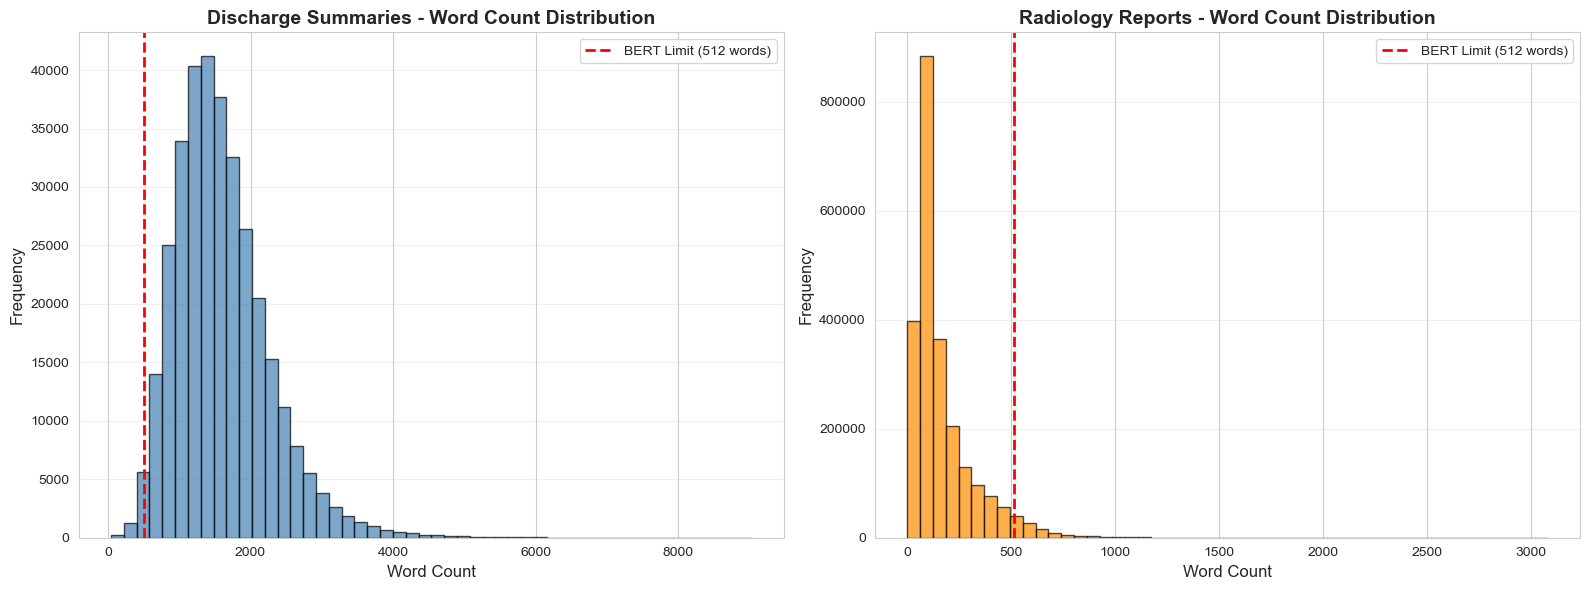

Histogram visualization complete.


In [13]:
# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# BERT limit marker
bert_limit = 512

# Plot discharge notes word count histogram
if 'word_count' in discharge_df.columns:
    axes[0].hist(discharge_df['word_count'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].axvline(x=bert_limit, color='red', linestyle='--', linewidth=2, label=f'BERT Limit ({bert_limit} words)')
    axes[0].set_xlabel('Word Count', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Discharge Summaries - Word Count Distribution', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(axis='y', alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'No word_count data for discharge notes', 
                 ha='center', va='center', transform=axes[0].transAxes)

# Plot radiology notes word count histogram
if 'word_count' in radiology_df.columns:
    axes[1].hist(radiology_df['word_count'], bins=50, color='darkorange', alpha=0.7, edgecolor='black')
    axes[1].axvline(x=bert_limit, color='red', linestyle='--', linewidth=2, label=f'BERT Limit ({bert_limit} words)')
    axes[1].set_xlabel('Word Count', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Radiology Reports - Word Count Distribution', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(axis='y', alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'No word_count data for radiology notes', 
                 ha='center', va='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

print("Histogram visualization complete.")

## Section 8: Sample Display

Display one full example of a discharge summary and one radiology report to inspect formatting, headers, and de-identification tags.

In [14]:
# Display a sample discharge summary
print("=" * 80)
print("SAMPLE DISCHARGE SUMMARY")
print("=" * 80)

if 'text' in discharge_df.columns and len(discharge_df) > 0:
    # Get the first non-empty text
    sample_discharge = discharge_df[discharge_df['text'].notna()].iloc[0]
    
    print(f"Note ID: {sample_discharge.get('note_id', 'N/A')}")
    print(f"Subject ID: {sample_discharge.get('subject_id', 'N/A')}")
    print(f"Hospital Admission ID: {sample_discharge.get('hadm_id', 'N/A')}")
    print(f"Word Count: {sample_discharge.get('word_count', 'N/A')}")
    print()
    print("Text Content:")
    print("-" * 80)
    print(sample_discharge['text'])
    print("-" * 80)
else:
    print("No discharge text available to display.")

print()

SAMPLE DISCHARGE SUMMARY
Note ID: 10000032-DS-21
Subject ID: 10000032
Hospital Admission ID: 22595853
Word Count: 1204

Text Content:
--------------------------------------------------------------------------------
 
Name:  ___                     Unit No:   ___
 
Admission Date:  ___              Discharge Date:   ___
 
Date of Birth:  ___             Sex:   F
 
Service: MEDICINE
 
Allergies: 
No Known Allergies / Adverse Drug Reactions
 
Attending: ___
 
Chief Complaint:
Worsening ABD distension and pain 
 
Major Surgical or Invasive Procedure:
Paracentesis

 
History of Present Illness:
___ HCV cirrhosis c/b ascites, hiv on ART, h/o IVDU, COPD, 
bioplar, PTSD, presented from OSH ED with worsening abd 
distension over past week.  
Pt reports self-discontinuing lasix and spirnolactone ___ weeks 
ago, because she feels like "they don't do anything" and that 
she "doesn't want to put more chemicals in her." She does not 
follow Na-restricted diets. In the past week, she notes that she 


In [15]:
# Display a sample radiology report
print("=" * 80)
print("SAMPLE RADIOLOGY REPORT")
print("=" * 80)

if 'text' in radiology_df.columns and len(radiology_df) > 0:
    # Get the first non-empty text
    sample_radiology = radiology_df[radiology_df['text'].notna()].iloc[0]
    
    print(f"Note ID: {sample_radiology.get('note_id', 'N/A')}")
    print(f"Subject ID: {sample_radiology.get('subject_id', 'N/A')}")
    print(f"Hospital Admission ID: {sample_radiology.get('hadm_id', 'N/A')}")
    print(f"Word Count: {sample_radiology.get('word_count', 'N/A')}")
    print()
    print("Text Content:")
    print("-" * 80)
    print(sample_radiology['text'])
    print("-" * 80)
else:
    print("No radiology text available to display.")

# **Key points:**
# - Load **all records** from discharge.csv.gz and radiology.csv.gz
# - Generate embeddings for only the **first 50 records** from each dataset
# - Use **Mean Pooling** of the last_hidden_state (NOT pooler_output)
# - Save results as parquet files

SAMPLE RADIOLOGY REPORT
Note ID: 10000032-RR-14
Subject ID: 10000032
Hospital Admission ID: 22595853.0
Word Count: 79

Text Content:
--------------------------------------------------------------------------------
EXAMINATION:  CHEST (PA AND LAT)

INDICATION:  ___ with new onset ascites  // eval for infection

TECHNIQUE:  Chest PA and lateral

COMPARISON:  None.

FINDINGS: 

There is no focal consolidation, pleural effusion or pneumothorax.  Bilateral
nodular opacities that most likely represent nipple shadows. The
cardiomediastinal silhouette is normal.  Clips project over the left lung,
potentially within the breast. The imaged upper abdomen is unremarkable.
Chronic deformity of the posterior left sixth and seventh ribs are noted.

IMPRESSION: 

No acute cardiopulmonary process.

--------------------------------------------------------------------------------


## Generate Embeddings for Clinical Notes

In [16]:
# Setup device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the Clinical ModernBERT model and tokenizer
model_name = "Simonlee711/Clinical_ModernBERT"
print(f"Loading model: {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, add_pooling_layer=False).to(device)

# Move model to device and set to evaluation mode
model = model.to(device)
model.eval()
print(f"Model loaded successfully and moved to {device}")

Using device: cpu
Loading model: Simonlee711/Clinical_ModernBERT...
Model loaded successfully and moved to cpu


In [17]:
def get_embeddings_with_mean_pooling(notes_text_list, batch_size=8):
    """
    Generate embeddings for a list of clinical notes using mean pooling.
    
    Args:
        notes_text_list: List of text strings to embed
        batch_size: Number of texts to process in each batch
    
    Returns:
        numpy array of embeddings with shape (num_texts, embedding_dim)
    """
    all_embeddings = []
    
    # Process texts in batches
    for i in tqdm(range(0, len(notes_text_list), batch_size), desc="Generating embeddings"):
        batch_texts = notes_text_list[i:i + batch_size]
        
        # Tokenize the batch
        encoded_input = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=8192,
            # Clinical_ModernBERT supports 8192 token context length
            return_tensors='pt'
        )
        
        # Move input tensors to device
        encoded_input = {key: val.to(device) for key, val in encoded_input.items()}
        
        # Generate embeddings without gradient computation
        with torch.no_grad():
            model_output = model(**encoded_input)
        
        # Extract last_hidden_state for mean pooling
        # Shape: (batch_size, sequence_length, hidden_size)
        last_hidden_state = model_output.last_hidden_state
        
        # Perform mean pooling
        # Expand attention_mask to match hidden_state dimensions
        # attention_mask shape: (batch_size, sequence_length)
        # We need: (batch_size, sequence_length, hidden_size)
        attention_mask = encoded_input['attention_mask'].unsqueeze(-1).expand(last_hidden_state.size())
        
        # Sum of token embeddings (masked by attention_mask)
        sum_embeddings = torch.sum(last_hidden_state * attention_mask, dim=1)
        
        # Sum of attention mask (to get the count of real tokens)
        sum_mask = torch.clamp(attention_mask.sum(dim=1), min=1e-6)
        
        # Calculate mean by dividing sum of embeddings by sum of mask
        mean_embeddings = sum_embeddings / sum_mask
        
        # Move to CPU and convert to numpy
        batch_embeddings = mean_embeddings.cpu().numpy()
        all_embeddings.append(batch_embeddings)
    
    # Concatenate all batch embeddings
    return np.vstack(all_embeddings)

In [18]:
# Load all records from discharge.csv.gz
print("Loading all records from discharge.csv.gz...")
discharge_sample = pd.read_csv(discharge_file, compression='gzip')
print(f"Loaded {len(discharge_sample)} discharge notes")
print(f"Columns: {list(discharge_sample.columns)}")

# Load all records from radiology.csv.gz
print("\nLoading all records from radiology.csv.gz...")
radiology_sample = pd.read_csv(radiology_file, compression='gzip')
print(f"Loaded {len(radiology_sample)} radiology notes")
print(f"Columns: {list(radiology_sample.columns)}")

Loading all records from discharge.csv.gz...
Loaded 331793 discharge notes
Columns: ['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq', 'charttime', 'storetime', 'text']

Loading all records from radiology.csv.gz...
Loaded 2321355 radiology notes
Columns: ['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq', 'charttime', 'storetime', 'text']


In [19]:
# Generate embeddings for first 50 discharge records
print("\nGenerating embeddings for first 50 discharge records...")
discharge_texts = discharge_sample['text'].head(50).fillna('').tolist()
discharge_embeddings = get_embeddings_with_mean_pooling(discharge_texts, batch_size=8)
print(f"Generated {len(discharge_embeddings)} embeddings with shape: {discharge_embeddings.shape}")

# Create DataFrame with required columns
discharge_sample_emb = pd.DataFrame({
    'note_id': discharge_sample['note_id'].head(50).values,
    'subject_id': discharge_sample['subject_id'].head(50).values,
    'hadm_id': discharge_sample['hadm_id'].head(50).values,
    'note_embedding': list(discharge_embeddings)
})

# Extract text column as a list
text_list = discharge_sample['text'].fillna('').tolist()
print(f"\nProcessing {len(text_list)} discharge notes...")

# Save to parquet
output_file = 'discharge_50_embeddings.parquet'
discharge_sample_emb.to_parquet(output_file, index=False)
print(f"\nSaved to: {output_file}")


Generating embeddings for first 50 discharge records...


Generating embeddings:  14%|█▍        | 1/7 [06:10<37:04, 370.74s/it]

KeyboardInterrupt



In [ ]:
# Generate embeddings for first 50 radiology records
print("\nGenerating embeddings for first 50 radiology records...")
radiology_texts = radiology_sample['text'].head(50).fillna('').tolist()
radiology_embeddings = get_embeddings_with_mean_pooling(radiology_texts, batch_size=8)
print(f"Generated {len(radiology_embeddings)} embeddings with shape: {radiology_embeddings.shape}")

# Create DataFrame with required columns
radiology_sample_emb = pd.DataFrame({
    'note_id': radiology_sample['note_id'].head(50).values,
    'subject_id': radiology_sample['subject_id'].head(50).values,
    'hadm_id': radiology_sample['hadm_id'].head(50).values,
    'note_embedding': list(radiology_embeddings)
})

print(f"Created radiology_sample_emb with shape: {radiology_sample_emb.shape}")
print(f"\nColumns: {list(radiology_sample_emb.columns)}")
print(f"\nFirst few rows:")
print(radiology_sample_emb.head())
print(f"\nEmbedding vector size: {len(radiology_sample_emb['note_embedding'].iloc[0])}")

In [ ]:
# Save to Parquet file
output_file = 'discharge_notes_embeddings.parquet'
discharge_sample_emb.to_parquet(output_file, index=False)
print(f"Saved embeddings to {output_file}")
print(f"Output DataFrame shape: {discharge_sample_emb.shape}")
print(f"Single embedding vector size: {len(discharge_sample_emb['note_embedding'].iloc[0])}")

# Save to parquet
output_file = 'radiology_50_embeddings.parquet'
radiology_sample_emb.to_parquet(output_file, index=False)
print(f"\nSaved to: {output_file}")

## Summary

This notebook has completed:

### Part 1: Full Dataset Analysis
- Analyzed complete datasets using chunking (10,000 rows per chunk)
- Calculated total records, unique IDs, and word count statistics
- Generated histogram comparing discharge and radiology note lengths

### Part 2: Sample Embeddings
- Loaded all records from discharge and radiology datasets
- Generated embeddings for 50 discharge notes and 50 radiology notes
- Used Clinical-ModernBERT with **mean pooling** strategy
- Saved embeddings to parquet files:
  - `discharge_50_embeddings.parquet`
  - `radiology_50_embeddings.parquet`

### Next Steps
- Review word count statistics to determine optimal model architecture
- Use the sample embeddings for downstream tasks (e.g., similarity analysis, clustering)
- Scale up embedding generation if needed using the same chunking approach